In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error

import time

In [7]:
df = pd.read_csv('./Data/airline_passengers.csv', index_col='Month', parse_dates=True)

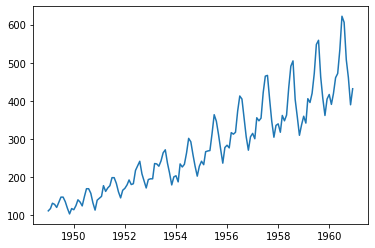

(144, 1)


In [10]:
plt.plot(df)
plt.show()
print(df.shape)

In [11]:
def train_test_split(data, n_test):
    return data[:-n_test], data[-n_test:]

In [12]:
def series_to_supervised(data, n_in, n_out=1):
    df = pd.DataFrame(data)
    cols = list()
    
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    for i in range(0, n_out):
        cols.append(df.shift(-1))
    agg = pd.concat(cols, axis=1)
    agg.dropna(inplace=True)
    return agg.values

In [15]:
def measure_rmse(actual, predicted):
    return np.sqrt(mean_squared_error(actual, predicted))

In [17]:
def model_fit(train, config):
    return None

In [18]:
def model_predict(model, history, config):
    return 0.0

In [19]:
def walk_forward_validation(data, n_test, cfg):
    predictions = list()
    train, test = train_test_split(data, n_test)
    model = model_fit(train, cfg)
    history = [x for x in train]
    for i in range(len(test)):
        yhat = model_predict(model, history, cfg)
        predictions.append(yhat)
        history.append(test[i])
    error = measure_rmse(test, predictions)
    print(' > %.3f' % error)
    return error

In [20]:
def repeat_evaluate(data, config, n_test, n_repeats=10):
    key = str(config)
    scores = [walk_forward_validation(data, n_test, config) for _ in range(n_repeats)]
    result = np.mean(scores)
    print('> Model[%s] %.3f' % (key, result))
    return (key, result)

In [33]:
def grid_search(data, cfg_list, n_test):
    scores = scores = [repeat_evaluate(data, cfg, n_test) for cfg in cfg_list]
    scores.sort(key=lambda tup: tup[1])
    return scores

## Worked Example

In [34]:
cfg_list = [1, 6, 12, 24, 36]

In [39]:
def model_predict(model, history, offset):
    return history[-offset]

In [40]:
data = df.values

In [41]:
n_test = 12

In [42]:
scores = grid_search(data, cfg_list, n_test)

 > 53.152
 > 53.152
 > 53.152
 > 53.152
 > 53.152
 > 53.152
 > 53.152
 > 53.152
 > 53.152
 > 53.152
> Model[1] 53.152
 > 126.735
 > 126.735
 > 126.735
 > 126.735
 > 126.735
 > 126.735
 > 126.735
 > 126.735
 > 126.735
 > 126.735
> Model[6] 126.735
 > 50.708
 > 50.708
 > 50.708
 > 50.708
 > 50.708
 > 50.708
 > 50.708
 > 50.708
 > 50.708
 > 50.708
> Model[12] 50.708
 > 97.110
 > 97.110
 > 97.110
 > 97.110
 > 97.110
 > 97.110
 > 97.110
 > 97.110
 > 97.110
 > 97.110
> Model[24] 97.110
 > 110.274
 > 110.274
 > 110.274
 > 110.274
 > 110.274
 > 110.274
 > 110.274
 > 110.274
 > 110.274
 > 110.274
> Model[36] 110.274


# Multilayer Perceptron Model

In [44]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

In [45]:
def difference(data, order):
    return [data[i] - data[i-order] for i in range(order, len(data))]

In [47]:
def model_fit(train, config):
    n_input, n_nodes, n_epochs, n_batch, n_diff = config
    if n_diff > 0:
        train = difference(train, n_diff)
    data = series_to_supervised(train, n_input)
    train_x, train_y = data[:, :-1], data[:, -1]
    inputs = Input(shape=n_input)
    d = Dense(n_nodes, activation='relu')(inputs)
    d = Dense(1)(d)
    model = Model(inputs, d)
    model.compile(loss='mse', optimizer='adam')
    model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0)
    return model

In [49]:
def model_predict(model, history, config):
    n_input, _, _, _, n_diff = config
    correction = 0.0
    if n_diff > 0:
        correction = history[-n_diff]
        history = difference(history, n_diff)
    x_input = np.array(history[-n_input:]).reshape((1, n_input))
    yhat = model.predict(x_input, verbose=0)
    return correction + yhat[0]

In [50]:
def model_configs():
    n_input = [12]
    n_nodes = [50, 100]
    n_epochs = [100]
    n_batch = [1, 150]
    n_diff = [0, 12]
    configs = list()
    for i in n_input:
        for j in n_nodes:
            for k in n_epochs:
                for l in n_batch:
                    for m in n_diff:
                        cfg = [i, j, k, l, m]
                        configs.append(cfg)
    print('Total configs: %d' % len(configs))
    return configs

In [51]:
data = df.values
n_test = 12
cfg_list = model_configs()

Total configs: 8


In [52]:
scores = grid_search(data, cfg_list, n_test)
print('done')

 > 50.855
 > 49.543
 > 52.052
 > 47.296
 > 51.748
 > 47.602
 > 47.328
 > 49.940
 > 47.951
 > 45.789
> Model[[12, 50, 100, 1, 0]] 49.010
 > 22.082
 > 23.412
 > 20.956
 > 23.638
 > 22.077
 > 30.015
 > 22.484
 > 24.413
 > 21.996
 > 23.591
> Model[[12, 50, 100, 1, 12]] 23.467
 > 77.028
 > 61.067
 > 56.004
 > 71.009
 > 78.346
 > 61.731
 > 64.405
 > 51.337
 > 75.911
 > 88.910
> Model[[12, 50, 100, 150, 0]] 68.575
 > 21.122
 > 20.089
 > 19.366
 > 20.917
 > 22.228
 > 21.359
 > 18.829
 > 21.059
 > 19.979
 > 20.322
> Model[[12, 50, 100, 150, 12]] 20.527
 > 45.372
 > 54.896
 > 50.308
 > 43.689
 > 48.785
 > 48.073
 > 52.743
 > 50.568
 > 50.725
 > 57.657
> Model[[12, 100, 100, 1, 0]] 50.282
 > 25.983
 > 24.608
 > 24.244
 > 26.153
 > 23.283
 > 24.376
 > 25.458
 > 22.593
 > 23.449
 > 22.782
> Model[[12, 100, 100, 1, 12]] 24.293
 > 74.117
 > 60.637
 > 47.464
 > 54.801
 > 63.690
 > 42.670
 > 73.197
 > 70.202
 > 64.183
 > 45.094
> Model[[12, 100, 100, 150, 0]] 59.606
 > 17.780
 > 19.361
 > 21.165
 > 18.

In [53]:
for cfg, error in scores[:3]:
    print(cfg, error)

[12, 100, 100, 150, 12] 19.636562127593386
[12, 50, 100, 150, 12] 20.52709134871789
[12, 50, 100, 1, 12] 23.466501566662856


# Convolutional Neural Network Model

In [54]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten

In [79]:
def model_fit(train, config):
    n_input, n_filters, n_kernel, n_epochs, n_batch, n_diff = config
    if n_diff > 0:
        train = difference(train, n_diff)
    data = series_to_supervised(train, n_input)
    train_x, train_y = data[:, :-1], data[:, -1]
    n_features = 1
    train_x = train_x.reshape((train_x.shape[0], train_x.shape[1], n_features))
    
    inputs = Input(shape = (n_input, n_features))
    c = Conv1D(filters=n_filters, kernel_size=n_kernel, activation='relu')(inputs)
    c = MaxPooling1D(pool_size=2)(c)
    c = Flatten()(c)
    c = Dense(1)(c)
    model = Model(inputs, c)
    model.compile(loss='mse', optimizer='adam')
    model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0)
    return model

In [80]:
def model_predict(model, history, config):
    n_input, _, _, _, _, n_diff = config
    correction = 0.0
    if n_diff > 0:
        correction = history[-n_diff]
        history = difference(history, n_diff)
    x_input = np.array(history[-n_input:]).reshape((1, n_input, 1))
    yhat = model.predict(x_input, verbose=0)
    return correction + yhat[0]

In [81]:
def model_configs():
    n_input = [12]
    n_filters = [32, 64]
    n_kernels = [3, 5]
    n_epochs = [100]
    n_batch = [1, 150]
    n_diff = [0, 12]
    configs = list()
    for i in n_input:
        for f in n_filters:
            for k in n_kernels:
                for e in n_epochs:
                    for b in n_batch:
                        for d in n_diff:
                            cfg = [i,f,k,e,b,d]
                            configs.append(cfg)
    print('Total configs: %d' % len(configs))
    return configs

In [82]:
data = df.values
n_test = 12
cfg_list = model_configs()

Total configs: 16


In [83]:
s = time.time()
scores = grid_search(data, cfg_list, n_test)
e = time.time()
print('Running Time : %d seconds' % (e-s))

 > 47.249
 > 45.081
 > 48.921
 > 53.223
 > 52.329
 > 44.923
 > 45.864
 > 47.325
 > 50.122
 > 48.942
> Model[[12, 32, 3, 100, 1, 0]] 48.398
 > 22.722
 > 22.948
 > 23.004
 > 22.826
 > 25.132
 > 24.070
 > 19.919
 > 20.374
 > 22.439
 > 21.342
> Model[[12, 32, 3, 100, 1, 12]] 22.478
 > 87.591
 > 71.742
 > 72.777
 > 86.176
 > 85.378
 > 77.785
 > 82.671
 > 81.630
 > 73.620
 > 99.254
> Model[[12, 32, 3, 100, 150, 0]] 81.862
 > 16.768
 > 20.325
 > 17.774
 > 18.769
 > 18.514
 > 19.372
 > 18.657
 > 19.387
 > 18.729
 > 18.400
> Model[[12, 32, 3, 100, 150, 12]] 18.670
 > 44.011
 > 49.398
 > 48.546
 > 47.447
 > 48.803
 > 51.190
 > 48.730
 > 51.964
 > 52.589
 > 52.124
> Model[[12, 32, 5, 100, 1, 0]] 49.480
 > 24.394
 > 26.451
 > 21.812
 > 21.454
 > 22.227
 > 20.732
 > 23.250
 > 22.345
 > 19.715
 > 20.909
> Model[[12, 32, 5, 100, 1, 12]] 22.329
 > 87.418
 > 81.760
 > 94.748
 > 75.390
 > 86.193
 > 82.786
 > 84.563
 > 77.004
 > 76.821
 > 102.390
> Model[[12, 32, 5, 100, 150, 0]] 84.907
 > 18.233
 > 19.2

# LSTM Network Model

In [84]:
from tensorflow.keras.layers import LSTM

In [85]:
def model_fit(train, config):
    n_input, n_nodes, n_epochs, n_batch, n_diff = config
    if n_diff > 0:
        train = difference(train, n_diff)
    data = series_to_supervised(train, n_in = n_input)
    train_x, train_y = data[:, :-1], data[:, -1]
    n_features = 1
    train_x = train_x.reshape((train_x.shape[0], train_x.shape[1], n_features))
    inputs = Input(shape=(n_input, n_features))
    l = LSTM(n_nodes, activation='relu')(inputs)
    l = Dense(n_nodes, activation='relu')(l)
    l = Dense(1)(l)
    model = Model(inputs, l)
    model.compile(loss='mse', optimizer='adam')
    model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0)
    return model

In [86]:
def model_predict(model, history, config):
    n_input, _, _, _, n_diff = config
    correction = 0.0
    if n_diff> 0:
        correction = history[-n_diff]
        history = difference(history, n_diff)
    x_input = np.array(history[-n_input:]).reshape((1, n_input, 1))
    yhat = model.predict(x_input, verbose=0)
    return correction + yhat[0]

In [89]:
def model_configs():
    n_input = [12]
    n_nodes = [100, 150]
    n_epochs = [50]
    n_batch = [1, 150]
    n_diff = [12]
    configs = list()
    for i in n_input:
        for n in n_nodes:
            for e in n_epochs:
                for b in n_batch:
                    for d in n_diff:
                        cfg = [i,n,e,b,d]
                        configs.append(cfg)
    print('Total configs: %d' % len(configs))
    return configs

In [90]:
data = df.values
n_test = 12
cfg_list = model_configs()

Total configs: 4


In [91]:
s = time.time()
scores = grid_search(data, cfg_list, n_test)
e = time.time()
print('Running Time : %d seconds' % (e-s))

 > 25.113
 > 23.377
 > 15.627
 > 29.399
 > 22.826
 > 23.346
 > 24.506
 > 24.279
 > 22.754
 > 25.609
> Model[[12, 100, 50, 1, 12]] 23.684
 > 19.182
 > 19.516
 > 17.153
 > 21.000
 > 23.508
 > 21.552
 > 20.273
 > 23.584
 > 18.860
 > 25.382
> Model[[12, 100, 50, 150, 12]] 21.001
 > 24.963
 > 24.748
 > 38.519
 > 25.252
 > 21.059
 > 25.087
 > 24.327
 > 26.631
 > 26.005
 > 25.943
> Model[[12, 150, 50, 1, 12]] 26.254
 > 18.240
 > 23.056
 > 21.645
 > 20.914
 > 23.832
 > 23.689
 > 22.335
 > 22.073
 > 21.387
 > 20.015
> Model[[12, 150, 50, 150, 12]] 21.719
Running Time : 479 seconds


In [92]:
for cfg, error in scores[:3]:
    print(cfg, error)

[12, 100, 50, 150, 12] 21.001008795955393
[12, 150, 50, 150, 12] 21.718614583175615
[12, 100, 50, 1, 12] 23.683683448772644
